In [25]:
import torch
import numpy as np
from pytorch3d.renderer import (
    look_at_view_transform,
    TexturesUV,
    FoVPerspectiveCameras,
    PointLights,
    MeshRenderer,
    RasterizationSettings,
    MeshRasterizer,
    SoftPhongShader,
    BlendParams,
    Textures,
    PerspectiveCameras

)
import cv2
import matplotlib.pyplot as plt
from pytorch3d.structures import Meshes
from PIL import Image
from pytorch3d.io import load_objs_as_meshes, load_obj

In [26]:
device='cuda:0'

In [27]:
verts, faces, aux = load_obj('/media/aaron/work/KIRI/ME_1015/P22_MOUTH_WIDE_OPEN/model_align.obj')

In [28]:
verts_uvs = aux.verts_uvs[None, ...]  # (1, V, 2)
faces_uvs = faces.textures_idx[None, ...]  # (1, F, 3)

texture_image = Image.open('/media/aaron/work/KIRI/ME_1015/P22_MOUTH_WIDE_OPEN/texture.jpg')
texture_image = texture_image.transpose(Image.FLIP_TOP_BOTTOM)
texture_image = np.array(texture_image)[::-1, :, :].copy()
texture_image = torch.from_numpy(texture_image).float() / 255.0
texture_image = texture_image.reshape((1, 4096, 4096, 3))

tex = Textures(verts_uvs=verts_uvs, faces_uvs=faces_uvs, maps=texture_image)

In [29]:
R = np.array([[-0.73400037  ,0.21025852 ,-0.64578232],
 [-0.13302601 ,-0.97696087, -0.16688783],
 [-0.66599365 ,-0.03658989,  0.74505949]])
t = np.array( [[-1.19397313],
 [ 0.87691801],
 [ 5.28206931]]).T
verts = torch.tensor(((R@verts.numpy().T).T + t), dtype=torch.float32)

In [30]:
meshes = Meshes(verts=[verts.to(device)], faces=[faces.verts_idx.to(device)], textures=tex.to(device))

In [31]:
focal = torch.tensor([2892.07091, 2895.418], dtype=torch.float32).to(device).unsqueeze(0)
princpt = torch.tensor([2003.92607, 1454.19411], dtype=torch.float32).to(device).unsqueeze(0)
cameras = PerspectiveCameras(device=device, focal_length=-focal, principal_point=princpt, in_ndc=False, image_size=((4032, 3024),))

In [32]:
raster_settings = RasterizationSettings(
            image_size=[4032, 3024],
            blur_radius=0.0,
            faces_per_pixel=1,
        )
lights = PointLights(device=device, location=[[0.0, 1.0, -10.0]])


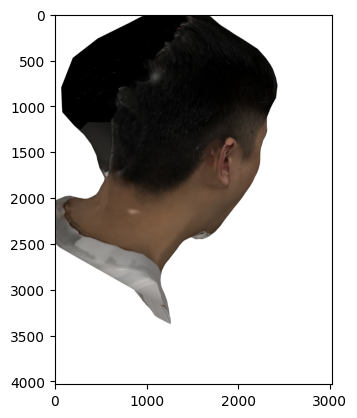

In [33]:
with torch.no_grad():
    renderer = MeshRenderer(
        rasterizer=MeshRasterizer(
            cameras=cameras,
            raster_settings=raster_settings
        ),
        shader=SoftPhongShader(
            device=device,
            cameras=cameras,
            lights=lights
        )
    )
    images = renderer(meshes, znear=0.0, zfar=10.0)
    img = 255*images.cpu().contiguous().numpy()
    img = img.astype('uint8')
    img = img[0, :, :, :3]
    # cv2.imwrite(f'../test_data/img-{index+1}.png',cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    # img = cv2.rotate(img, cv2.ROTATE_180)
    plt.imshow(img)